## Cartopy and the Shuttle Radar Topography Map data

The SRTM project provides a global land elevation model at a resolution of (roughly) 30m. That's a useful thing to be able to access - either as raw data or simply for plotting into maps. Here are some examples of methods to access, process and display this data using the cartopy interfaces.

For more information on the project: http://www2.jpl.nasa.gov/srtm/




In [1]:
%pylab inline

import cartopy.crs as ccrs
from cartopy.io import srtm
import matplotlib.pyplot as plt

from cartopy.io import PostprocessedRasterSource, RasterSourceContainer, LocatedImage
from cartopy.io.srtm import SRTM3Source

from osgeo import gdal
from osgeo import gdal_array

import cartopy.feature as cfeature


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Region of interest

map_extent = [ -120, -117, 33, 36]

lon0 = map_extent[0]
lat0 = map_extent[2]

# High res coastline

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")


ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

/opt/conda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://dds.cr.usgs.gov/srtm/version2_1/SRTM3/North_America/N33W120.hgt.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://dds.cr.usgs.gov/srtm/version2_1/SRTM3/North_America/N34W120.hgt.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://dds.cr.usgs.gov/srtm/version2_1/SRTM3/North_America/N35W120.hgt.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://dds.cr.usgs.gov/srtm/version2_1/SRTM3/North_America/N33W119.hgt.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python2.7/site-packages/cartopy/io/__init

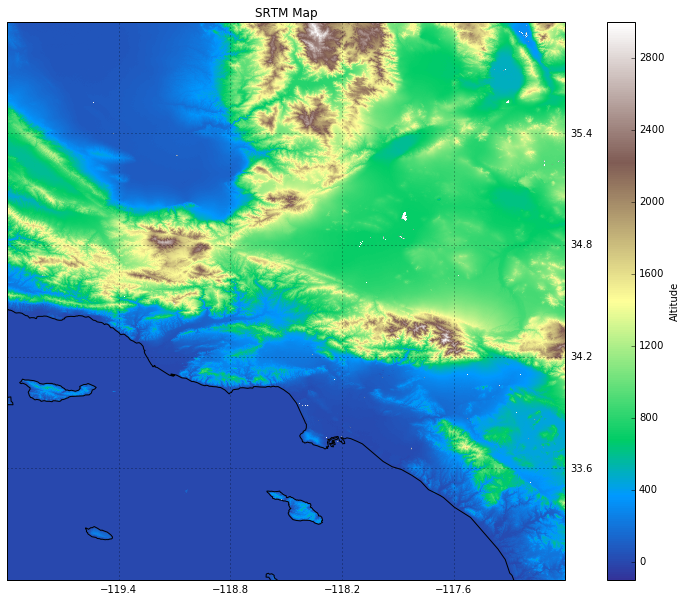

In [3]:
# SRTM - how to grab the data and plot it as an image (in the usual way)

# There may be some "download" warnings but this is simply a result of the way that the SRTM 
# module caches data the first time that it needs a tile. Replotting will be a lot quicker.
 


plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

elev, crs, extent = SRTM3Source().combined(lon0, lat0, 3, 3)

# Take out low points 
elev = np.ma.masked_less_equal(elev, -100, copy=False)

plt.imshow(elev, extent=extent, transform=crs,
           cmap='terrain', origin='lower', vmin=-100.0, vmax=3000)

cb = plt.colorbar(orientation='vertical')
cb.set_label('Altitude')
plt.title("SRTM Map")
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False




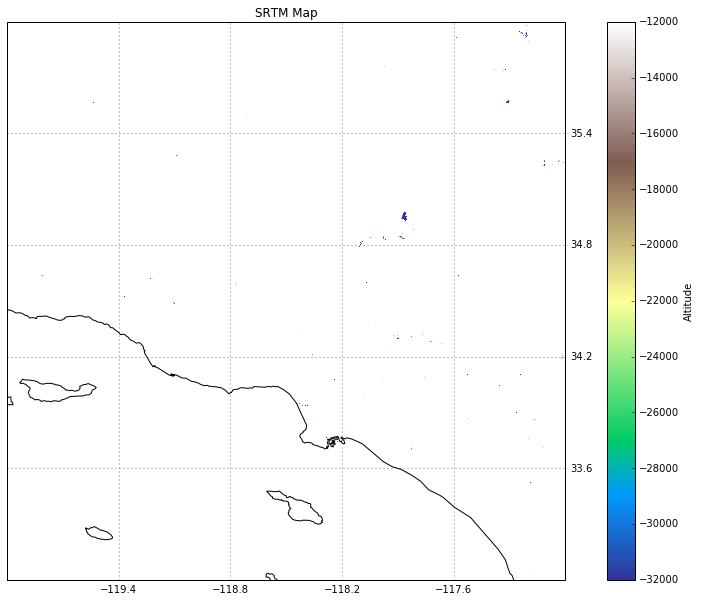

In [4]:
# The original data have some holes which can be seen in this image. Previously we just clipped
# them out by setting a minimum in the allowable values to plot. 

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

elev, crs, extent = SRTM3Source().combined(lon0, lat0, 3, 3)


# elev = np.ma.masked_less_equal(elev, -100, copy=False)

plt.imshow(elev, extent=extent, transform=crs,
           cmap='terrain', origin='lower', vmin=-32000.0, vmax=-12000)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)


cb = plt.colorbar(orientation='vertical')
cb.set_label('Altitude')
plt.title("SRTM Map")
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

In [5]:
# Patching holes in the data by a smoothing / interpolation routine from gdal

elev, crs, extent = SRTM3Source().combined(lon0, lat0, 3, 3)

old_elev = elev.copy()

src_ds = gdal_array.OpenArray(elev)

srcband = src_ds.GetRasterBand(1)
dstband = srcband
maskband = srcband 

smoothing_iterations = 0   # iterations applied after patching
options = []
max_distance = 15           # distance in pixels used to find data to patch
result = gdal.FillNodata(dstband, maskband,
                         max_distance, smoothing_iterations, options,
                         callback=None)

elev = dstband.ReadAsArray()

# It's probably worth looking at these figures to see what is going on 

print "Number of points previously out of range ", np.count_nonzero( old_elev < -12000)
print "Number of points currently out of range ", np.count_nonzero( elev < -12000)
print "Number of points changed: ", np.count_nonzero(elev-old_elev)
print "Range of changed points: ",  elev[elev != old_elev].min(), " ", elev[elev != old_elev].max()


Number of points previously out of range  4649
Number of points currently out of range  15
Number of points changed:  130837
Range of changed points:  1.0   2696.04272461


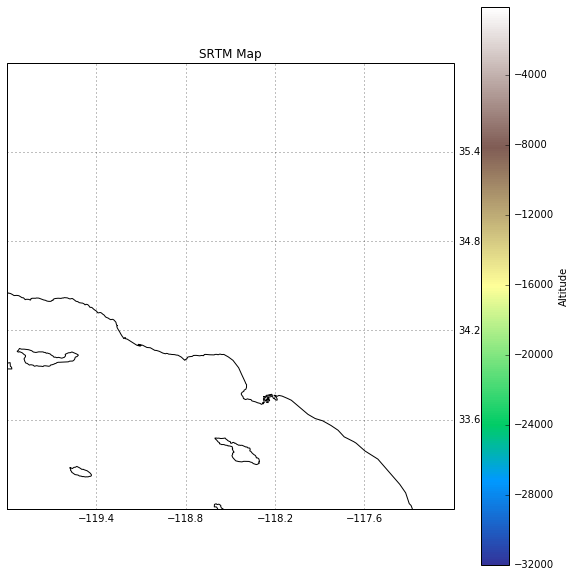

In [6]:
# And plotting

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

plt.imshow(elev, extent=extent, transform=crs, cmap='terrain', origin='lower', vmin=-32000.0, vmax=-100.0)
ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

cb = plt.colorbar(orientation='vertical')
cb.set_label('Altitude')
plt.title("SRTM Map")
gl = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_left = False

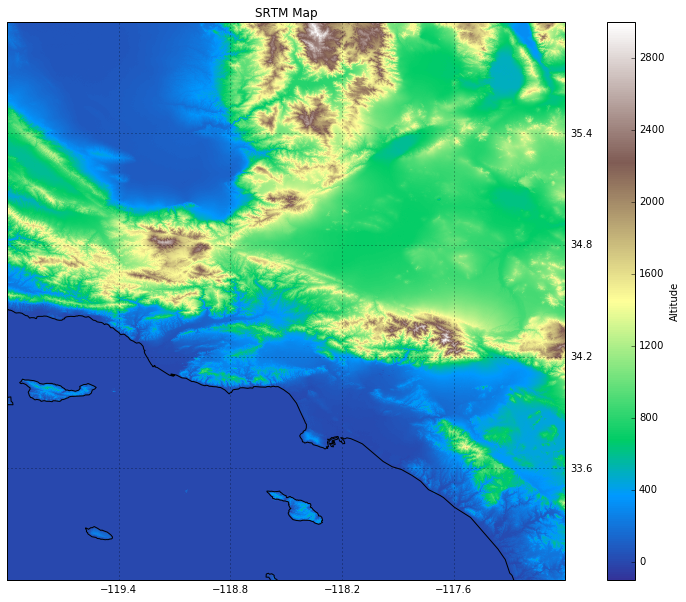

In [7]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

plt.imshow(elev, extent=extent, transform=crs,
           cmap='terrain', origin='lower', vmin=-100.0, vmax=3000)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

cb = plt.colorbar(orientation='vertical')
cb.set_label('Altitude')
plt.title("SRTM Map")
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

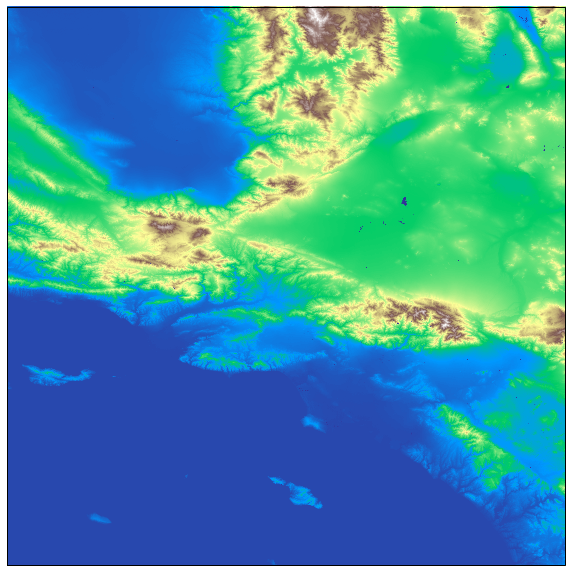

In [8]:
# Here is a completely different way to do this !! 

# Rather than downloading data, we can make use of on-demand downloading
# through interfaces provided by cartopy. This might save us managing a
# huge amount of data but the manipulations we used routinely above now
# have to be handled by helper functions handed into the cartopy classes.


# The "container" is like a placeholder for what will need to be called 
# when the plotting routines need to grab data

srtm = RasterSourceContainer(SRTM3Source())

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

data_norm = matplotlib.colors.Normalize(vmin=-100, vmax=3000)
ax.add_raster(srtm, cmap='terrain', norm=data_norm)


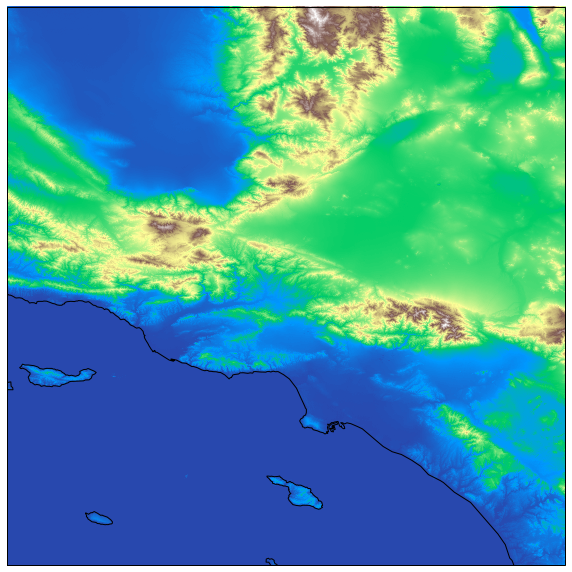

In [9]:
from cartopy.io import srtm as csrtm


globaletopo       = gdal.Open("Resources/color_etopo1_ice_low.tif")
globaletopo_img   = globaletopo.ReadAsArray().transpose(1,2,0)

def fill_holes(located_elevations):
    """
    Given an array of elevations in a LocatedImage, fill any holes in
    the data and add a relief (shadows) to give a realistic 3d appearance.

    """
    new_elevations = csrtm.fill_gaps(located_elevations.image, max_distance=15)
    return LocatedImage(new_elevations, located_elevations.extent)


srtm = PostprocessedRasterSource(SRTM3Source(), fill_holes)

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

norm = matplotlib.colors.Normalize(vmin=-100, vmax=3000)
ax.add_raster(srtm, cmap='terrain', norm=norm)
ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)


/opt/conda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


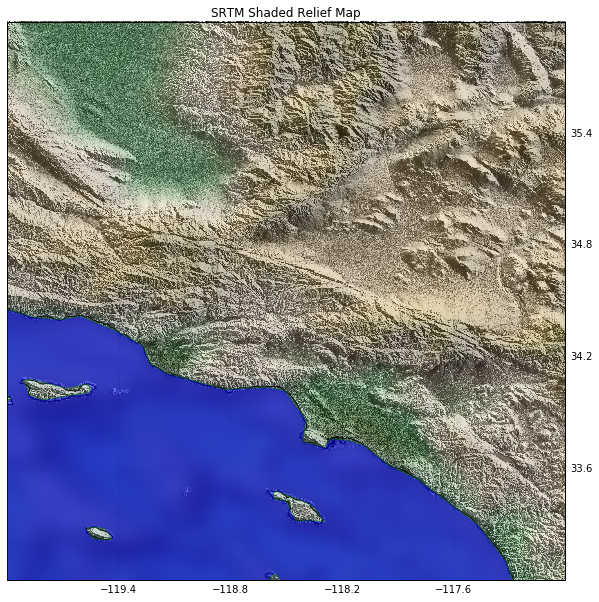

In [10]:
# Shuttle radar shaded relief map 

from cartopy.io import srtm as csrtm

globaletopo       = gdal.Open("Resources/color_etopo1_ice_low.tif")
globaletopo_img   = globaletopo.ReadAsArray().transpose(1,2,0)

def fill_and_shade(located_elevations):
    """
    Given an array of elevations in a LocatedImage, fill any holes in
    the data and add a relief (shadows) to give a realistic 3d appearance.

    """
    new_elevations = csrtm.fill_gaps(located_elevations.image, max_distance=15)
    new_img = csrtm.add_shading(new_elevations, azimuth=135, altitude=33)
    return LocatedImage(new_img, located_elevations.extent)


# Define a raster source which uses the SRTM3 data and applies the
# fill_and_shade function when the data is retrieved.

shaded_srtm = PostprocessedRasterSource(SRTM3Source(), fill_and_shade)

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

# Add the shaded SRTM source to our map with a grayscale colormap.

ax.add_raster(shaded_srtm, cmap='Greys', zorder=1)

plt.imshow(globaletopo_img, zorder=2, transform=ccrs.PlateCarree(), 
           extent = [-180.0, 180.0, -90.0, 90.0], interpolation='bicubic', alpha=0.333)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(ocean,  zorder=4, alpha = 0.5)



# This data is high resolution, so pick a small area which has some
# interesting orography.


plt.title("SRTM Shaded Relief Map")

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
